In [19]:
! ls Data
print('')
! ls Data/output/

1519759656_39328483.csv
2017 PMP Data Final No Duplicates.xlsx
Federal_VDC_Relation_web_clean.xlsx
Federal_VDC_Relation_web.xlsx
nepalmonitor-reports.csv
nepal_population_household_ward-2011.csv
NM_2016_17export.csv
npl_polbanda_adm5_wad_25k_sdn_wgs84.csv
output

District_Province_Population  pop_incidents_VDC.csv
NM_2016_17clean.csv	      sources_vdc.csv


In [24]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)



#Import Main Data Frames
cleanpath='Data/output/NM_2016_17clean.csv'#clean 2017 dataset
newpath = 'Data/nepalmonitor-reports.csv'#NM latest export - new site version for hold out set
df = pd.read_csv(cleanpath)
new_df = pd.read_csv(newpath)

print(df.shape[0],'x',df.shape[1])
print(new_df.shape[0], 'x',new_df.shape[1])

6630 x 68
5127 x 55


In [25]:
# convert 'INCIDENT DATE' column to date time objects (and limit to 2017) (and 18)
df['INCIDENT DATE'] = pd.to_datetime(df.loc[:,'INCIDENT DATE'])
df.index  = df['INCIDENT DATE']
df = df['2017']

new_df['Event Date'] = pd.to_datetime(new_df.loc[:,'Event Date'])
new_df['Publication Date'] = pd.to_datetime(new_df.loc[:,'Publication Date'])
new_df.index = new_df['Publication Date']
#new_df = new_df['2018'] < taken out to have part of the 2017 data

print(df.shape)
print(new_df.shape)

(3541, 68)
(5127, 55)


### Match (concat?_ 2017 and 2018 data

In [26]:
drop = ['CATEGORY','Municipality/VDC(New)','Ward(New)','Ward','Crosscutting issues','Weapon 2','Actor 2 entity name',
        'Number of Deaths','Development Region','Number of Injuries','Verification Feedback',
        'Event Date - Peace Monitoring','INCIDENT NUMBER','LATITUDE','LONGITUDE',
        'VERIFIED','LOCATION','Zone','District(New)','Election-related  specific cause primary',
        'Election-related specific cause secondary','INCIDENT DATE','INCIDENT TITLE']

new_drop = ['#','Title','Nepali Title', 'Ward','Publication Date','Event Date',
            'Province','Nepali Description','Tags','Location','Latitude','Longitude']

train_df = df.dropna(axis=1, how='all')#.sort_index(axis=1)
test_df = new_df.dropna(axis=1, how='all')#.sort_index(axis=1)


train_df.drop(drop, axis=1, inplace=True)
test_df.drop(new_drop, axis=1, inplace=True)

train_df.rename(columns={'Actor 1 Entity Name': 'Actor 1 - Entity',
                         #': 'Actor 2 - Entity',
                         'Actor 1 - Perpetrator Type':'Actor 1 - Affiliation',
                         'Perpetrator 2 - if two-sided violence':'Actor 2 - Affiliation',
                         'Actor 1 - Youth -25 years or below- involvement': 'Actor 1 - Youth/non-youth',
                         'Actor 2 - Youth -25 years or below- involvement': 'Actor 2 - Youth/non-youth',
                         'Actor 2 Numbers':'Actor 2 - Number of people',
                         
                        }, inplace=True)

test_df = test_df.reindex(columns=['Description', 'HLCIT Code', 'Location Accuracy', 'District', 'Municipality/VDC',
 'Source', 'Source Type', 'Duration - only applicable to non-violent forms', 
 'Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 
 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 
 'Cause - Secondary','Actor 1 - Number of people','Actor 1 - Affiliation', 'Actor 1 - Entity', 
 'Actor 1 - Youth/non-youth', 'Actor 2 - Number of people', 'Actor 2 - Target', 'Actor 2 - Affiliation',
 'Actor 2 - Youth/non-youth', 'Total killed', 'Female killed', 'Youth killed', 'Total injured', 'Female injured',
 'Youth injured', 'Total raped', 'Female raped', 'Youth raped', 'Total abducted', 'Female abducted', 
 'Youth abducted', 'Total damaged buildings', 'Severely damaged buildings', 'Total damaged vehicles', 
 'Severely damaged vehicles'])

#train_df.sort_index(axis=1, inplace=True)
#test_df.sort_index(axis=1, inplace=True)

print(train_df.shape,test_df.shape)

for col in zip(train_df.columns,test_df.columns):
    print(col)
#print(test_df.columns)

(3541, 40) (5127, 40)
('DESCRIPTION', 'Description')
('HLCIT CODE', 'HLCIT Code')
('LOCATION ACCURACY', 'Location Accuracy')
('District', 'District')
('Municipality/VDC', 'Municipality/VDC')
('SOURCE', 'Source')
('SOURCE TYPE', 'Source Type')
('Duration - only applicable to non-violent forms', 'Duration - only applicable to non-violent forms')
('Violent vs non-violent', 'Violent / Nonviolent')
('One-sided vs two-sided', 'Onesided / Twosided')
('Collective vs interpersonal', 'Collective / Interpersonal')
('Event form - primary', 'Event Form - Primary')
('Event form - secondary', 'Event Form - Secondary')
('Weapon', 'Weapons')
('Cause - primary', 'Cause - Primary')
('Cause - secondary', 'Cause - Secondary')
('Actor 1 - Number of People', 'Actor 1 - Number of people')
('Actor 1 - Affiliation', 'Actor 1 - Affiliation')
('Actor 1 - Entity', 'Actor 1 - Entity')
('Actor 1 - Youth/non-youth', 'Actor 1 - Youth/non-youth')
('Actor 2 - Number of people', 'Actor 2 - Number of people')
('Target - i

/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nhorning/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [27]:
train_df.columns = test_df.columns
full_df = test_df#train_df.append(test_df) < it looks like the variables are coded differently let's just use 1 dataset for now
full_df['Total killed'] = (full_df.loc[:,'Total killed'] == '1').astype(float)
full_df.head()

,Description,HLCIT Code,Location Accuracy,District,Municipality/VDC,Source,Source Type,Duration - only applicable to non-violent forms,Violent / Nonviolent,Onesided / Twosided,...,Total raped,Female raped,Youth raped,Total abducted,Female abducted,Youth abducted,Total damaged buildings,Severely damaged buildings,Total damaged vehicles,Severely damaged vehicles
Publication Date,,,,,,,,,,,,,,,,,,,,,
2018-11-15,People in Pushpalal Chok of Nepalgunj were ter...,NP0557201,municipality,Banke,Nepalgunj,http://kathmandupost.ekantipur.com/news/2018-1...,National/Online Media,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-14,The police have rescued 35 child workers from...,NP0327101,municipality,Kathmandu,Kathmandu,https://myrepublica.nagariknetwork.com/news/35...,National/Online Media,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-15,Police have launched an investigation after a ...,NP0217310,municipality,Dhanusha,Bideha,http://annapurnapost.com/news/112833\nhttps://...,National/Online Media,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-13,A man attacked three persons with a Khukuri—a ...,524 3 09 46 5 002 3,ward,Taplejung,Phungling,http://kathmandupost.ekantipur.com/news/2018-1...,National/Online Media,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-13,Police have arrested 54 years old ward secreta...,524 3 09 46 5 002 4,ward,Rupandehi,Tillotama,http://inseconline.org/en/news/witch-craft-all...,National/Online Media\nINSEC,NaN,violent,onesided,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Start with some time series analysis - predict levels of violence based on previous weeks.

In [28]:
#One-hot encode categorical columns
dummies = ['Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 
 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 
 'Cause - Secondary','Actor 1 - Number of people','Actor 1 - Affiliation', 'Actor 1 - Entity', 
 'Actor 1 - Youth/non-youth', 'Actor 2 - Number of people', 'Actor 2 - Target', 'Actor 2 - Affiliation',
 'Actor 2 - Youth/non-youth']
incidents_date = pd.get_dummies(full_df, columns=dummies)

in_week = incidents_date.resample('W').sum()
in_day = incidents_date.resample('D').sum()
in_week.head()
print(in_week.shape)
print(in_day.shape)

(78, 450)
(542, 450)


In [29]:
in_day.columns

Index(['Total killed', 'Female killed', 'Youth killed', 'Total injured',
       'Female injured', 'Youth injured', 'Total raped', 'Female raped',
       'Youth raped', 'Total abducted',
       ...
       'Actor 2 - Affiliation_Security forces - Police',
       'Actor 2 - Affiliation_Security forces - Police\nSecurity forces - Police',
       'Actor 2 - Affiliation_Security forces - Security forces (unspecified)',
       'Actor 2 - Affiliation_Security forces - Security forces (unspecified)\nSecurity forces - Security forces (unspecified)',
       'Actor 2 - Affiliation_Students', 'Actor 2 - Affiliation_Unclear',
       'Actor 2 - Youth/non-youth_na', 'Actor 2 - Youth/non-youth_noyouth',
       'Actor 2 - Youth/non-youth_unknown', 'Actor 2 - Youth/non-youth_youth'],
      dtype='object', length=450)

In [30]:
#function for converting pandas time series df to training set for supervised learning
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
        https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
#Create a time shifted dataframe of all variables.
lookback = 20
time_shift_week = series_to_supervised(in_week, lookback, dropnan=False)
time_shift_day = series_to_supervised(in_day, lookback, dropnan=False)
print(time_shift_day.shape)
time_shift_day.head()

(542, 9450)


,Total killed(t-20),Female killed(t-20),Youth killed(t-20),Total injured(t-20),Female injured(t-20),Youth injured(t-20),Total raped(t-20),Female raped(t-20),Youth raped(t-20),Total abducted(t-20),...,Actor 2 - Affiliation_Security forces - Police(t),Actor 2 - Affiliation_Security forces - Police Security forces - Police(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified) Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Students(t),Actor 2 - Affiliation_Unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Publication Date,,,,,,,,,,,,,,,,,,,,,
2017-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train your predictive model on the above data frame.
For any given variable t-n represents one step back. 
try to find a way to predict everything with everything? find out which are the most acurate?
 - let's start with one. 
  - note... at some point try to preserve labels, so you know what is actually contributing. 

must create train test sets of the array above
test reserve will be this years data


In [32]:
#Create X

y_week = time_shift_week.loc['2017','Total killed(t)':]

y_day = time_shift_day.loc['2017','Total killed(t)':]

X_week = time_shift_week.loc['2017',:'Actor 2 - Youth/non-youth_youth(t-1)']#you can probably create this string later to try different numbers
#X = pd.concat([df1, df2], ignore_index=False, keys=['t-1','t-2']).swaplevel().sort_index()
X_day = time_shift_day.loc['2017',:'Actor 2 - Youth/non-youth_youth(t-1)']
#testing hold out set
holdout_week = time_shift_week.loc['2018',:'Actor 2 - Youth/non-youth_youth(t-1)']
holdout_day = time_shift_day.loc['2018',:'Actor 2 - Youth/non-youth_youth(t-1)']
y_day.head()

,Total killed(t),Female killed(t),Youth killed(t),Total injured(t),Female injured(t),Youth injured(t),Total raped(t),Female raped(t),Youth raped(t),Total abducted(t),...,Actor 2 - Affiliation_Security forces - Police(t),Actor 2 - Affiliation_Security forces - Police Security forces - Police(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Security forces - Security forces (unspecified) Security forces - Security forces (unspecified)(t),Actor 2 - Affiliation_Students(t),Actor 2 - Affiliation_Unclear(t),Actor 2 - Youth/non-youth_na(t),Actor 2 - Youth/non-youth_noyouth(t),Actor 2 - Youth/non-youth_unknown(t),Actor 2 - Youth/non-youth_youth(t)
Publication Date,,,,,,,,,,,,,,,,,,,,,
2017-05-24,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


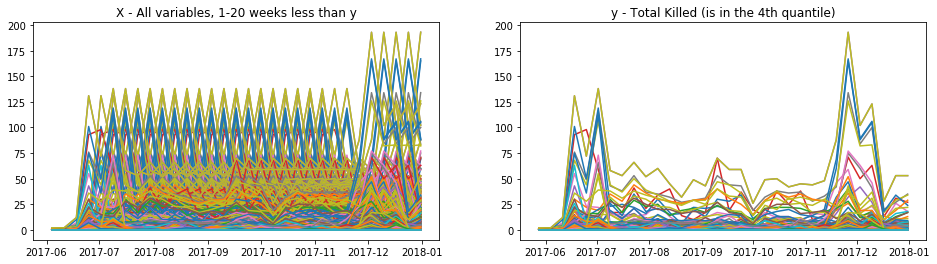

/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


train score: 0.954545454545
test score: 0.4
confusion matrix
   n,p
n [1 0 0 0 0 0 0] 
p [0 0 0 1 0 0 0]
crossvalidation mean: -0.793417700004 [-0.30837004  0.44388271 -2.51576577]


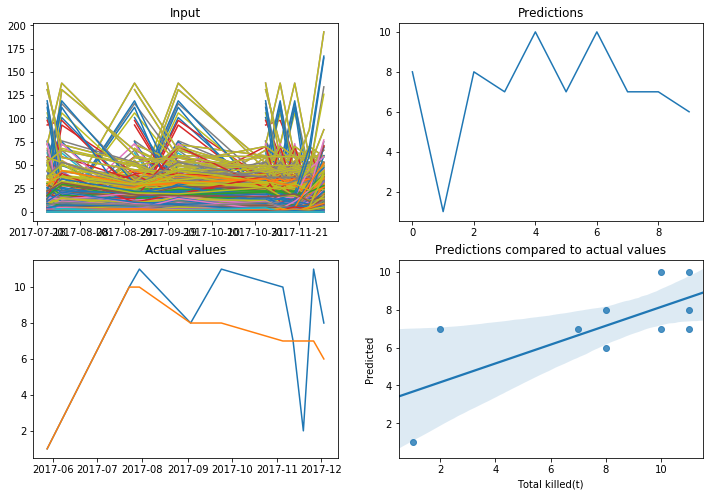

In [47]:
#Train and test a model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

#create imputer for nan values 
imp = Imputer(missing_values='NaN', strategy = 'most_frequent')

def plot_model(X_test, y_test, y_pred):
    sync = pd.DataFrame({'Actual Values':y_test, 'Predictions':y_pred}, index=y_test.index)
        
    f, (ax0, ax1) = plt.subplots(2,2, figsize=(12,8))
    ax0[0].plot(X_test.sort_index())
    ax0[0].set_title('Input')
    ax0[1].plot(y_pred)
    ax0[1].set_title('Predictions')
    ax1[0].plot(sync.sort_index())
    ax1[0].set_title('Actual values')
    #sns.grid.ax1[0].legend()
    sns.regplot(y_test, y_pred)
    ax1[1].set_title('Predictions compared to actual values')
    ax1[1].set_ylabel('Predicted')
    plt.show()

    
def test_model(X_train, X_test, y_train, y_test, model):
    #for later

    #create preprocessing pipline with imputation 
    pipeline = Pipeline([('imputation', imp,),('model',model)])

    #fit the model to the training set
    pipeline.fit(X_train, y_train)

    #test model
    y_pred = pipeline.predict(X_test)
    
    #score model
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    
    return pipeline, train_score, test_score, cm, 

    
#create fuction to train model and find a variable than can be predicted from the previous week's data
def try_model(X, y, model, verbose=0):

 

    #Split X and Y into training and testing sets... #we'll use this years data as the hold out set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

    #create preprocessing pipline with imputation 
    pipeline = Pipeline([('imputation', imp,),('model',model)])

    #fit the model to the training set
    pipeline.fit(X_train, y_train)

    #test model
    y_pred = pipeline.predict(X_test)
    
    #score model
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    #r_2 = r2_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    #pipeline, train_score, test_score, cm = test_model(X_train, X_test, y_train, y_test, model)
    
    #crossvalidate accross the dataset
   
    eye = np.eye(X_test.shape[1])
    log_proba = pd.DataFrame(pipeline.predict_log_proba(eye), index = X.columns)
    
    #check if the true negatives and true positives are at least as big as the false negatives and false positives   
    cv_done = False
    cv_score = np.empty(3)
    if cm.shape == (2,2):
        if cm[0][0] > cm[1][0]*2 and cm[1][1] > cm[0][1]*2:
            cv_score = cross_val_score(pipeline, X, y, cv=3,)# scoring='r2')
            cv_done = True
    else:
        r_2 = r2_score(y_test, y_pred)
        if r_2 > 0:
            cv_score = cross_val_score(pipeline, X, y, cv=3, scoring='r2')
            cv_done = True
    
    if verbose > 0:
        #print scores
        print('train score:', train_score )
        print('test score:', test_score)
        #print('R2 score:', r_2)
        print('confusion matrix\n   n,p\nn', cm[0],'\np',cm[1])
        if cv_done == True:
            print('crossvalidation mean:',cv_score.mean(), cv_score)
        else:
            print('Confusion matrix is bad. No crossvalidation')
        #print('Top Feature Probabilities:', log_proba.sort_values(1, axis=1, ascending=False))
        #print('Bottom Feature Probabilities:', bottom_prob)
    
    if verbose > 1:
        #Plot what these look like
        plot_model(X_test, y_test, y_pred)
       
    return cv_score, test_score, cm, log_proba

#define y
y = y_week.loc[:,'Total killed(t)']# > in_week.loc['2017':,'Total killed'].quantile(.5)

#Plot what X and y look like
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(X_week)
ax1.set_title('X - All variables, 1-{} weeks less than y'.format(int(lookback)))
ax2.plot(y_week)
ax2.set_title('y - Total Killed (is in the 4th quantile)')
plt.show()

#give the function to try the model a dry run
dry_run = try_model(X_week, y, MultinomialNB(), verbose = 2)


In [45]:
#find which variables have the best crossvalidation scores
def find_var (X, df, model, n_true, verbose=False):
    scores = pd.DataFrame(index=df.columns[1:], columns=['cv_mean','test_score','confusion_matrix','pc_true'])
    for var in df.columns:
        y = df[var] > df[var].quantile(.5)
        #X = time_shift.loc[:,'var1(t-1)':'var340(t-1)']
        n_class = y.nunique()
        n_bins = 10
        #n_true = 10
        pc_true = sum(y == 1)/len(y)*100
        
        if verbose == True:
            print('\n')
            print(var)
        if verbose == False:
                print('.', end=' ')
        if pc_true > n_true: #make it a percentage
      
            cv_score, test_score, cm, log_proba = try_model(X, y, model, verbose = verbose)
        
                  
            scores['cv_mean'][var] = cv_score.mean()
            scores['test_score'][var] = test_score
            scores['confusion_matrix'][var] = cm
            scores['pc_true'][var] = pc_true
        
    
    print('bing!')   
    return scores
cv_scores = find_var(X_week, y_week, MultinomialNB(), n_true=20, verbose=1)
top10 = cv_scores.sort_values('cv_mean', ascending=False)[:10]
top10



Total killed(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 1.0
test score: 0.5
confusion matrix
   n,p
n [5 2] 
p [3 0]
Confusion matrix is bad. No crossvalidation


Female killed(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.6
confusion matrix
   n,p
n [3 3] 
p [1 3]
Confusion matrix is bad. No crossvalidation


Youth killed(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.4
confusion matrix
   n,p
n [4 2] 
p [4 0]
Confusion matrix is bad. No crossvalidation


Total injured(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.909090909091
test score: 0.3
confusion matrix
   n,p
n [0 5] 
p [2 3]
Confusion matrix is bad. No crossvalidation


Female injured(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.909090909091
test score: 0.6
confusion matrix
   n,p
n [4 1] 
p [3 2]
Confusion matrix is bad. No crossvalidation


Youth injured(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.6
confusion matrix
   n,p
n [5 1] 
p [3 1]
Confusion matrix is bad. No crossvalidation


Total raped(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.909090909091
test score: 0.8
confusion matrix
   n,p
n [5 1] 
p [1 3]
crossvalidation mean: 0.406060606061 [ 0.18181818  0.63636364  0.4       ]


Female raped(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.818181818182
test score: 0.5
confusion matrix
   n,p
n [4 3] 
p [2 1]
Confusion matrix is bad. No crossvalidation


Youth raped(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 1.0
test score: 0.5
confusion matrix
   n,p
n [4 1] 
p [4 1]
Confusion matrix is bad. No crossvalidation


Total abducted(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.4
confusion matrix
   n,p
n [3 3] 
p [3 1]
Confusion matrix is bad. No crossvalidation


Female abducted(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.8
confusion matrix
   n,p
n [8 0] 
p [2 0]
Confusion matrix is bad. No crossvalidation


Youth abducted(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.5
confusion matrix
   n,p
n [5 1] 
p [4 0]
Confusion matrix is bad. No crossvalidation


Total damaged buildings(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.909090909091
test score: 0.7
confusion matrix
   n,p
n [5 3] 
p [0 2]
Confusion matrix is bad. No crossvalidation


Severely damaged buildings(t)


Total damaged vehicles(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 1.0
test score: 0.5
confusion matrix
   n,p
n [4 1] 
p [4 1]
Confusion matrix is bad. No crossvalidation


Severely damaged vehicles(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 1.0
test score: 0.5
confusion matrix
   n,p
n [5 1] 
p [4 0]
Confusion matrix is bad. No crossvalidation


Violent / Nonviolent_nonviolent(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.7
confusion matrix
   n,p
n [4 2] 
p [1 3]
Confusion matrix is bad. No crossvalidation


Violent / Nonviolent_violent(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.909090909091
test score: 0.7
confusion matrix
   n,p
n [2 2] 
p [1 5]
Confusion matrix is bad. No crossvalidation


Onesided / Twosided_onesided(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.3
confusion matrix
   n,p
n [2 6] 
p [1 1]
Confusion matrix is bad. No crossvalidation


Onesided / Twosided_twosided(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.863636363636
test score: 0.6
confusion matrix
   n,p
n [4 0] 
p [4 2]
Confusion matrix is bad. No crossvalidation


Collective / Interpersonal_collective(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


train score: 0.954545454545
test score: 0.7
confusion matrix
   n,p
n [2 2] 
p [1 5]
Confusion matrix is bad. No crossvalidation


Collective / Interpersonal_interpersonal(t)


/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:538: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


KeyboardInterrupt: 

In [28]:
#top10 = cv_scores.sort_values('cv_mean', ascending=False)[:10]
cv_scores.tail()

,cv_mean,test_score,confusion_matrix,pc_true
Actor 2 - Youth/non-youth_Youth(t),NaN,NaN,NaN,NaN
Actor 2 - Youth/non-youth_na(t),NaN,NaN,NaN,NaN
Actor 2 - Youth/non-youth_noyouth(t),NaN,NaN,NaN,NaN
Actor 2 - Youth/non-youth_unknown(t),NaN,NaN,NaN,NaN
Actor 2 - Youth/non-youth_youth(t),NaN,NaN,NaN,NaN


In [ ]:
def interpet_prob(log_proba):
    pd.set_option('display.max_colwidth', 200)
    print(np.exp(log_proba).sort_values(0)[:5])
    print(np.exp(log_proba).sort_values(1)[:5])
    sns.heatmap(np.exp(log_proba).sort_values(1))
    plt.show()

for cat in top10.index:
    print('\n',cat)
    y = in_week[cat] > in_week[cat].quantile(.75)
    cv_score, test_score, cm, log_proba = try_model(X, y, MultinomialNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, MultinomialNB(), verbose = 2)
        interpet_prob(log_proba)
        test_model()

Note effectiveness of MultinomialNB() at predicting demonstrations and sit ins based on indicators from the previous weeks. Indicators that ... and testing on the hold out set of this years data.

In [189]:
cv_scores_day = find_var(X_day, in_day, MultinomialNB(), n_true=20, verbose=False)
top10_day = cv_scores_day.sort_values('cv_mean', ascending=False)[:10]
top10_day

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bing!


,cv_mean,test_score,confusion_matrix,pc_true
Actor 1 - Youth -25 years or below- involvement_Unknown,0.772313,0.890909,"[[84, 5], [7, 14]]",22.8022
Total Injured,5.43472e-322,0.718182,"[[66, 15], [16, 13]]",23.0769
Rape or Attempted Rape - Youth - 25 years or below,5.43472e-322,0.463636,"[[36, 52], [7, 15]]",23.9011
Actor 2 - Youth -25 years or below- involvement_No-youth,5.43472e-322,0.4,"[[30, 54], [12, 14]]",22.5275
Perpetrator 2 - if two-sided violence_ (),5.43472e-322,0.790909,"[[75, 10], [13, 12]]",23.0769
Target - if one-sided violence_Political organization/Politician - UML and affiliated org (0402),5.43472e-322,0.745455,"[[75, 11], [17, 7]]",23.6264
"Target - if one-sided violence_Civil state institutions - Local authorities (incl VDC, district, gov. line agencies at local level except education and health) (0204)",5.43472e-322,0.663636,"[[67, 22], [15, 6]]",20.3297
Actor 1 - Perpetrator Type_Unclear (9999),5.43472e-322,0.827273,"[[80, 9], [10, 11]]",20.6044
Actor 1 - Perpetrator Type_Security forces - Police (0101),5.43472e-322,0.709091,"[[76, 11], [21, 2]]",21.1538
Crosscutting issues_Elections,5.43472e-322,0.8,"[[77, 13], [9, 11]]",21.4286



 Actor 1 - Youth -25 years or below- involvement_Unknown

 Total Injured

 Rape or Attempted Rape - Youth - 25 years or below

 Actor 2 - Youth -25 years or below- involvement_No-youth

 Perpetrator 2 - if two-sided violence_ ()

 Target - if one-sided violence_Political organization/Politician - UML and affiliated org (0402)

 Target - if one-sided violence_Civil state institutions - Local authorities (incl VDC, district, gov. line agencies at local level except education and health) (0204)

 Actor 1 - Perpetrator Type_Unclear (9999)

 Actor 1 - Perpetrator Type_Security forces - Police (0101)

 Crosscutting issues_Elections
train score: 0.830708661417
test score: 0.736363636364
confusion matrix
   n,p
n [62  3] 
p [26 19]
crossvalidation mean: 0.758185431062 [ 0.77868852  0.7107438   0.78512397]


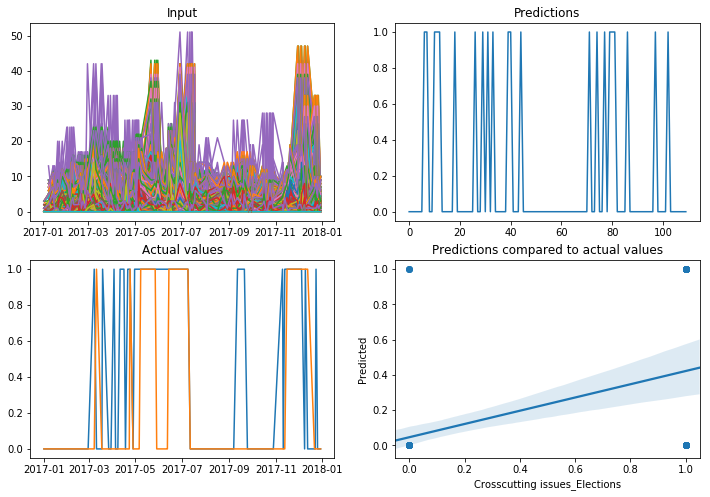

                                                                                                                       0         1
Event form - secondary_Non-violent - Arrest (politically significant) (28)(t-1)                                 0.103680  0.896320
Target - if one-sided violence_Political organization/Politician - RPP (0407)(t-7)                              0.106487  0.893513
Event form - secondary_Non-violent - Other forms of non-violent political protest (24)(t-2)                     0.115902  0.884098
Event form - primary_Violent - Symbolic violence (09)(t-2)                                                      0.127143  0.872857
Target - if one-sided violence_Political organization/Politician - CPN (Chand) and affiliated org (0404)(t-11)  0.127143  0.872857
                                                                                                            0         1
Actor 1 - Perpetrator Type_Health sector/health workers, doctors (2201)(t-11)                 

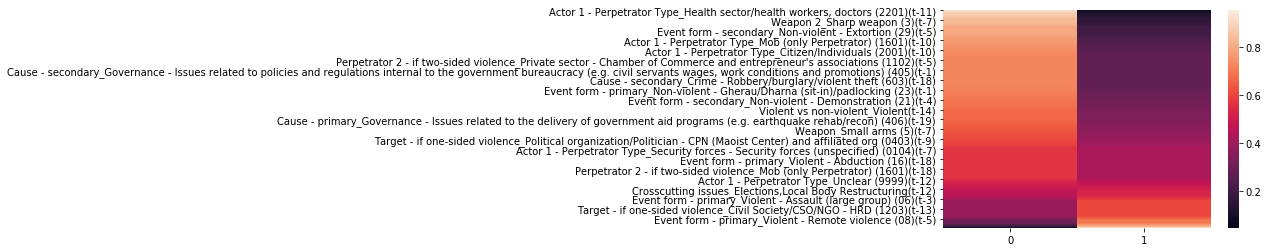

In [233]:
for cat in top10_day.index:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, MultinomialNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X_day, y, MultinomialNB(), verbose = 2)
        interpet_prob(log_proba)

In [193]:
from sklearn.naive_bayes import BernoulliNB

BNB_scores = find_var(X, in_week, BernoulliNB(), n_true=20, verbose=False)
BNB_top10 = BNB_scores.sort_values('cv_mean', ascending=False)[:10]
BNB_top10

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . bing!


,cv_mean,test_score,confusion_matrix,pc_true
"Crosscutting issues_Constitutional Process,Local Body Restructuring",0.830065,0.875,"[[10, 1], [1, 4]]",22.6415
Target - if one-sided violence_Group of civilians (only Target) (1701),0.755991,0.9375,"[[14, 0], [1, 1]]",20.7547
Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404),0.755418,0.9375,"[[12, 1], [0, 3]]",24.5283
Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election,0.754902,0.875,"[[13, 0], [2, 1]]",22.6415
"Crosscutting issues_Elections,Constitutional Process",0.736383,0.9375,"[[12, 0], [1, 3]]",22.6415
Cause - secondary_ (),7.90505e-323,0.6875,"[[11, 0], [5, 0]]",24.5283
Actor 1 - Perpetrator Type_Criminal (1401),7.90505e-323,0.75,"[[12, 0], [4, 0]]",24.5283
Actor 1 - Perpetrator Type_Citizen/Individuals (2001),7.90505e-323,0.8125,"[[13, 0], [3, 0]]",20.7547
Crosscutting issues_GBV,7.90505e-323,0.875,"[[14, 0], [2, 0]]",20.7547
Crosscutting issues_Elections,7.90505e-323,0.8125,"[[13, 0], [3, 0]]",24.5283


In [228]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_week[cat] > in_week[cat].quantile(.75)
    cv_score, test_score, cm, log_proba = try_model(X, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)


 Crosscutting issues_Constitutional Process,Local Body Restructuring

 Target - if one-sided violence_Group of civilians (only Target) (1701)

 Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404)

 Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election

 Crosscutting issues_Elections,Constitutional Process


In [230]:
for cat in BNB_top10.index[:5]:
    print('\n',cat)
    y = in_day[cat] > 1
    cv_score, test_score, cm, log_proba = try_model(X_day, y, BernoulliNB(), verbose = 0)
    if cv_score.mean() > .70:
        try_model(X, y, BernoulliNB(), verbose = 2)
        interpet_prob(log_proba)


 Crosscutting issues_Constitutional Process,Local Body Restructuring

 Target - if one-sided violence_Group of civilians (only Target) (1701)

 Actor 1 - Perpetrator Type_Political organization/Politician - CPN (Chand) and affiliated org (0404)

 Election-related specific cause secondary_Constestation regarding implementation and legitimacy of election

 Crosscutting issues_Elections,Constitutional Process


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
rgs = RandomForestRegressor()
cls = RandomForestClassifier()
y = 
try_model(X, y, cls)

In [ ]:
top6 = cv_scores.sort_values('cv_mean', ascending=False)[:6]
top6

In [ ]:
s2 = pd.Series([6,8,3], index=list('abc'))
s4 = pd.Series([1,2,3], index=list('abc'))

s2 + s4